# UCI Dataset: Wine Quality

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

import ld
from utlis import vectorize_tensor, reconstruct_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)
k = 5
bandwidth = 0.05
bandwidth_AE = 0.05
eps = np.asarray(1.0e-5)

### Dataset

In [3]:
class NumpyDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        """
        Args:
            features (np.ndarray): Feature matrix.
            labels (np.ndarray): Label array.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.features[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Normalize transform for UCI dataset
class Normalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean, dtype=torch.float32)
        self.std = torch.tensor(std, dtype=torch.float32)

    def __call__(self, sample):
        # std is 0 for constant features, so we add a small epsilon to avoid division by zero
        return (sample - self.mean) / (self.std + eps)

# Custom transformation for adding Gaussian noise
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        noise = torch.randn_like(sample) * self.std + self.mean
        return sample + noise

# Composite transformation to combine Normalize and AddGaussianNoise
class CompositeTransform:
    def __init__(self, transforms):
        """
        Args:
            transforms (list): List of transformations to apply in sequence.
        """
        self.transforms = transforms

    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [4]:
UCI_id = 186 # https://archive.ics.uci.edu/dataset/186/wine-quality
test_size = 0.2

UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# normalize to [0, 1]
X = (X - X.min()) / (X.max() - X.min())

# extend features to 12 dimensions
X = np.pad(X, ((0, 0), (0, 12 - X.shape[1])), mode="constant")

# Find unique labels
unique_labels = np.unique(Y)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = int(len(Y) * (1 - test_size))
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

train_dataset = NumpyDataset(X_train, Y_train, transform=Normalize(mean, std))
test_dataset = NumpyDataset(X_test, Y_test, transform=Normalize(mean, std))

/home/pbb/miniconda3/envs/ig/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
D = X_train.shape[1]
S = (2, 2, 3)

if np.prod(S) != D:
    raise ValueError("The product of the tensor structure is not equal to the feature dimension")

new_sample_size_per_digit = int(n_train * 0.2 // len(unique_labels))

# Print dataset statistics
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"New sample size: {new_sample_size_per_digit * len(unique_labels)}")
print(f"Number of classes: {len(unique_labels)}")
print(f"Number of features: {D-1}")

Train size: 5197
Test size: 1300
New sample size: 1036
Number of classes: 7
Number of features: 11


## Pseudo-Non-Linear Data Augmentation

### Legendre Decomposition (Many-Body Approximation)

In [6]:
B_LD = ld.default_B(S, 2, cp.get_array_module(X_train[0]))
print(f"Dimension of Base Sub-Manifold: {B_LD.shape[0]}")

scaleX_class = []
theta_class = []

def LD_helper(i, class_):
    _, _, scaleX, _, theta = ld.LD(X_train_class[class_][i].reshape(*S), B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, theta)

results = Parallel(n_jobs=30)(delayed(LD_helper)(i, class_) for class_ in unique_labels for i in range(len(X_train_class[class_])))

len_class = 0
for class_ in unique_labels:
    scaleX_list = []
    theta_list = []

    for i in range(len(X_train_class[class_])):
        result = results[i + len_class]

        scaleX_list.append(result[0])
        theta_list.append(result[1])

    len_class += len(X_train_class[class_])

    scaleX_class.append(scaleX_list)
    theta_class.append(theta_list)

Dimension of Base Sub-Manifold: 10


#### Fitting on Projected Points

In [7]:
sampled_theta_class = []

for class_ in unique_labels:
    reduced_theta = vectorize_tensor(np.array(theta_class[class_]), B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (new_sample_size_per_digit, *S), B_LD)

    sampled_theta_class.append(sampled_theta)

#### Construct Local Data Sub-Manifold

In [8]:
# Construct the constrained coordinates
B_BP = ld.default_B(S, 1, cp.get_array_module(X_train[0]))
print(f"Dimension of Local Data Sub-Manifold: {D - B_BP.shape[0]}")

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for class_ in unique_labels:
    eta_hat_list = []
    for i in range(X_train_class[class_].shape[0]):
        xp = cp.get_array_module(X_train_class[class_][i])
        P = (X_train_class[class_][i].reshape(*S) + eps) / scaleX_class[class_][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)
    eta_hat_list = cp.asarray(eta_hat_list)

    eta_hat_class.append(eta_hat_list)

Dimension of Local Data Sub-Manifold: 7


#### Backward Projection

In [9]:
def BP_helper(i, class_):
    N = ld.kNN(sampled_theta_class[class_][i], np.array(theta_class[class_]), k=k)
    avg_scale = np.mean(np.array(scaleX_class[class_])[N])
    avg_eta_hat = np.mean(eta_hat_class[class_][N], axis=0)

    _, _, P, theta = ld.BP(sampled_theta_class[class_][i], [(X_train_class[class_][j].reshape(*S) + eps) / scaleX_class[class_][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=5e-2, exit_abs=True)
    X_recons_ = P.reshape(-1)
    return (theta, X_recons_)

results = Parallel(n_jobs=30)(delayed(BP_helper)(i, class_) for i in range(new_sample_size_per_digit) for class_ in unique_labels)

sampled_theta_BP_class = []
sampled_X_BP_class = []

for class_ in unique_labels:
    sampled_theta_BP = []
    sampled_X_BP = []
    for i in range(new_sample_size_per_digit):
        result = results[i + new_sample_size_per_digit * class_]

        sampled_theta_BP.append(result[0])
        sampled_X_BP.append(result[1])

    sampled_theta_BP_class.append(np.array(sampled_theta_BP))
    sampled_X_BP_class.append(np.array(sampled_X_BP))

## Data Augmentation with Autoencoder

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_size=D, hidden_size=B_LD.shape[0], z_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=D, hidden_size=B_LD.shape[0], z_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [11]:
train_loader_original = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


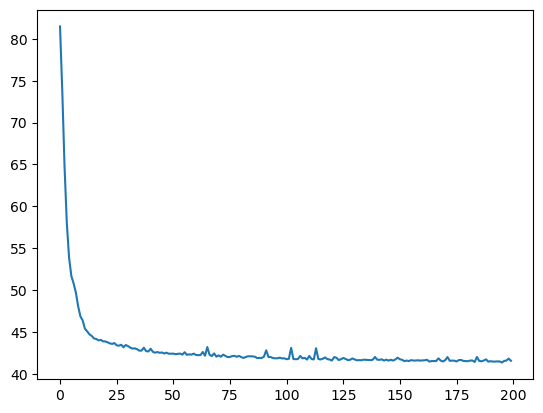

In [12]:
train_loss = []
num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (x , _) in train_loader_original:
        x = x.to(device)
        x = x.flatten(1)
        latents = enc(x)
        output = dec(latents)
        loss = loss_fn(output , x)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

In [13]:
representation = None
all_labels = []

with torch.no_grad():
    for (xs , labels) in train_loader_original:
        xs = xs.to(device)
        xs = xs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(xs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [14]:
sampled_X_AE_class = []

for class_ in unique_labels:
    sampled_X_AE_list = []

    rep = representation[np.argwhere(all_labels == class_)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=new_sample_size_per_digit)
    for i in range(new_sample_size_per_digit):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_X_AE_list.append(pred.flatten())

    sampled_X_AE_class.append(sampled_X_AE_list)

## Classification Performance

### Dataset Preparation

In [15]:
# Helper function to create a DataLoader for augmented datasets
def prepare_augmented_dataset(original_dataset, augmented_data, augmented_labels, transform, batch_size):
    # Create dataset from augmented data
    augmented_dataset = NumpyDataset(features=augmented_data, labels=augmented_labels, transform=transform)

    # Combine with the original dataset
    combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

    # Create a DataLoader for the combined dataset
    return DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

# Main function to prepare datasets and loaders
def create_datasets_and_loaders(batch_size=64):
    # Define transformations
    transform_standard = CompositeTransform([
        Normalize(mean, std),
        AddGaussianNoise(mean=0.0, std=std[:-1].min()/4)  # Add Gaussian noise with 1/4 of the standard deviation (omit the last dummy feature)
    ])
    transform_none = Normalize(mean, std)

    train_standard = NumpyDataset(X_train, Y_train, transform=transform_standard)
    train_none = NumpyDataset(X_train, Y_train, transform=transform_none)

    augmented_data_PNL = []
    labels_PNL = []
    augmented_data_AE = []
    labels_AE = []

    for class_ in range(len(unique_labels)):
        for data_PNL in sampled_X_BP_class[class_]:
            augmented_data_PNL.append(data_PNL)
            labels_PNL.append(class_)

        for data_AE in sampled_X_AE_class[class_]:
            augmented_data_AE.append(data_AE)
            labels_AE.append(class_)

    augmented_data_PNL = np.array(augmented_data_PNL)
    labels_PNL = np.array(labels_PNL)
    augmented_data_AE = np.array(augmented_data_AE)
    labels_AE = np.array(labels_AE)

    mean_LD = augmented_data_PNL.mean(axis=0)
    std_LD = augmented_data_PNL.std(axis=0)
    transform_none_LD = Normalize(mean_LD, std_LD)

    mean_AE = augmented_data_AE.mean(axis=0)
    std_AE = augmented_data_AE.std(axis=0)
    transform_none_AE = Normalize(mean_AE, std_AE)

    # Combine original with augmented data
    train_loader_PNL = prepare_augmented_dataset(train_none, augmented_data_PNL, labels_PNL, transform_none_LD, batch_size)
    train_loader_AE = prepare_augmented_dataset(train_none, augmented_data_AE, labels_AE, transform_none_AE, batch_size)

    # DataLoader for the original dataset only
    train_loader_standard = DataLoader(train_standard, batch_size=batch_size, shuffle=True)
    train_loader_none = DataLoader(train_none, batch_size=batch_size, shuffle=True)

    return {
        "standard": train_loader_standard,
        "none": train_loader_none,
        "PNL_augmented": train_loader_PNL,
        "AE_augmented": train_loader_AE,
    }

loaders = create_datasets_and_loaders(batch_size=64)

# Check each DataLoader
for name, loader in loaders.items():
    print(f"{name} loader:")
    for images, labels in loader:
        print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        break

train_loader_standard = loaders["standard"]
train_loader_none = loaders["none"]
train_loader_PNL = loaders["PNL_augmented"]
train_loader_AE = loaders["AE_augmented"]

standard loader:
Images shape: torch.Size([64, 12]), Labels shape: torch.Size([64])
none loader:
Images shape: torch.Size([64, 12]), Labels shape: torch.Size([64])
PNL_augmented loader:
Images shape: torch.Size([64, 12]), Labels shape: torch.Size([64])
AE_augmented loader:
Images shape: torch.Size([64, 12]), Labels shape: torch.Size([64])


### MLP Model

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_classes=len(unique_labels)):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        x = self.activation(self.hidden_layer(x))  # Apply hidden layer + ReLU
        x = self.output_layer(x)  # Apply output layer
        return x

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def bootstrapping(train_loader, test_dataset, num_epochs=10, learning_rate=1e-1, n_bootstrap=20, device='cuda'):
    """
    Train the Logistic Regression model on the training dataset, and evaluate it using bootstrapping on the test dataset.

    Args:
        train_loader: DataLoader for training data.
        test_dataset: Dataset object for the test data.
        num_epochs: Number of epochs for training.
        learning_rate: Learning rate for the optimizer.
        device: Device to run the training on ('cuda' or 'cpu').

    Returns:
        Prints the mean accuracy and 95% confidence interval after bootstrapping.
    """
    # Initialize the model, loss, and optimizer
    model = MLP(input_size=D ,num_classes=len(unique_labels)).to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decay LR every 30 epochs

    # Train the model
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

    # Perform bootstrapping
    accuracies = []

    num_test_samples = len(test_dataset) // 2
    for i in range(n_bootstrap):
        indices = torch.randint(len(test_dataset), size=(num_test_samples,))
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=num_test_samples, shuffle=False)

        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)

    # Compute statistics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"Standard deviation: {std_accuracy:.2f}")

### Dataset Performance

In [17]:
bootstrapping(train_loader_none, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.2273
Epoch [2/50], Loss: 1.0999
Epoch [3/50], Loss: 1.0840
Epoch [4/50], Loss: 1.0702
Epoch [5/50], Loss: 1.0739
Epoch [6/50], Loss: 1.0713
Epoch [7/50], Loss: 1.0714
Epoch [8/50], Loss: 1.0704
Epoch [9/50], Loss: 1.0686
Epoch [10/50], Loss: 1.0616
Epoch [11/50], Loss: 1.0707
Epoch [12/50], Loss: 1.0627
Epoch [13/50], Loss: 1.0640
Epoch [14/50], Loss: 1.0636
Epoch [15/50], Loss: 1.0579
Epoch [16/50], Loss: 1.0639
Epoch [17/50], Loss: 1.0556
Epoch [18/50], Loss: 1.0565
Epoch [19/50], Loss: 1.0567
Epoch [20/50], Loss: 1.0639
Epoch [21/50], Loss: 1.0622
Epoch [22/50], Loss: 1.0703
Epoch [23/50], Loss: 1.0556
Epoch [24/50], Loss: 1.0529
Epoch [25/50], Loss: 1.0581
Epoch [26/50], Loss: 1.0561
Epoch [27/50], Loss: 1.0565
Epoch [28/50], Loss: 1.0538
Epoch [29/50], Loss: 1.0610
Epoch [30/50], Loss: 1.0605
Epoch [31/50], Loss: 1.0296
Epoch [32/50], Loss: 1.0184
Epoch [33/50], Loss: 1.0223
Epoch [34/50], Loss: 1.0179
Epoch [35/50], Loss: 1.0225
Epoch [36/50], Loss: 1.0160
E

In [18]:
bootstrapping(train_loader_standard, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.2329
Epoch [2/50], Loss: 1.1050
Epoch [3/50], Loss: 1.0896
Epoch [4/50], Loss: 1.0901
Epoch [5/50], Loss: 1.0809
Epoch [6/50], Loss: 1.0720
Epoch [7/50], Loss: 1.0741
Epoch [8/50], Loss: 1.0682
Epoch [9/50], Loss: 1.0719
Epoch [10/50], Loss: 1.0644
Epoch [11/50], Loss: 1.0616
Epoch [12/50], Loss: 1.0692
Epoch [13/50], Loss: 1.0590
Epoch [14/50], Loss: 1.0693
Epoch [15/50], Loss: 1.0698
Epoch [16/50], Loss: 1.0522
Epoch [17/50], Loss: 1.0552
Epoch [18/50], Loss: 1.0537
Epoch [19/50], Loss: 1.0555
Epoch [20/50], Loss: 1.0557
Epoch [21/50], Loss: 1.0581
Epoch [22/50], Loss: 1.0601
Epoch [23/50], Loss: 1.0549
Epoch [24/50], Loss: 1.0477
Epoch [25/50], Loss: 1.0487
Epoch [26/50], Loss: 1.0525
Epoch [27/50], Loss: 1.0518
Epoch [28/50], Loss: 1.0520
Epoch [29/50], Loss: 1.0526
Epoch [30/50], Loss: 1.0509
Epoch [31/50], Loss: 1.0295
Epoch [32/50], Loss: 1.0200
Epoch [33/50], Loss: 1.0198
Epoch [34/50], Loss: 1.0177
Epoch [35/50], Loss: 1.0156
Epoch [36/50], Loss: 1.0152
E

In [19]:
bootstrapping(train_loader_PNL, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.4651
Epoch [2/50], Loss: 1.3870
Epoch [3/50], Loss: 1.3758
Epoch [4/50], Loss: 1.3548
Epoch [5/50], Loss: 1.3365
Epoch [6/50], Loss: 1.3395
Epoch [7/50], Loss: 1.3345
Epoch [8/50], Loss: 1.3333
Epoch [9/50], Loss: 1.3311
Epoch [10/50], Loss: 1.3297
Epoch [11/50], Loss: 1.3233
Epoch [12/50], Loss: 1.3297
Epoch [13/50], Loss: 1.3231
Epoch [14/50], Loss: 1.3237
Epoch [15/50], Loss: 1.3132
Epoch [16/50], Loss: 1.3221
Epoch [17/50], Loss: 1.3213
Epoch [18/50], Loss: 1.3220
Epoch [19/50], Loss: 1.3164
Epoch [20/50], Loss: 1.3253
Epoch [21/50], Loss: 1.3186
Epoch [22/50], Loss: 1.3196
Epoch [23/50], Loss: 1.3152
Epoch [24/50], Loss: 1.3112
Epoch [25/50], Loss: 1.3143
Epoch [26/50], Loss: 1.3184
Epoch [27/50], Loss: 1.3111
Epoch [28/50], Loss: 1.3108
Epoch [29/50], Loss: 1.3185
Epoch [30/50], Loss: 1.3165
Epoch [31/50], Loss: 1.2881
Epoch [32/50], Loss: 1.2777
Epoch [33/50], Loss: 1.2754
Epoch [34/50], Loss: 1.2721
Epoch [35/50], Loss: 1.2729
Epoch [36/50], Loss: 1.2722
E

In [20]:
bootstrapping(train_loader_AE, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 1.4360
Epoch [2/50], Loss: 1.3269
Epoch [3/50], Loss: 1.3015
Epoch [4/50], Loss: 1.2860
Epoch [5/50], Loss: 1.2620
Epoch [6/50], Loss: 1.2439
Epoch [7/50], Loss: 1.2238
Epoch [8/50], Loss: 1.2268
Epoch [9/50], Loss: 1.2034
Epoch [10/50], Loss: 1.1910
Epoch [11/50], Loss: 1.1946
Epoch [12/50], Loss: 1.1871
Epoch [13/50], Loss: 1.1944
Epoch [14/50], Loss: 1.1750
Epoch [15/50], Loss: 1.1745
Epoch [16/50], Loss: 1.1723
Epoch [17/50], Loss: 1.1717
Epoch [18/50], Loss: 1.1723
Epoch [19/50], Loss: 1.1782
Epoch [20/50], Loss: 1.1672
Epoch [21/50], Loss: 1.1752
Epoch [22/50], Loss: 1.1779
Epoch [23/50], Loss: 1.1713
Epoch [24/50], Loss: 1.1686
Epoch [25/50], Loss: 1.1718
Epoch [26/50], Loss: 1.1701
Epoch [27/50], Loss: 1.1693
Epoch [28/50], Loss: 1.1599
Epoch [29/50], Loss: 1.1761
Epoch [30/50], Loss: 1.1590
Epoch [31/50], Loss: 1.1325
Epoch [32/50], Loss: 1.1243
Epoch [33/50], Loss: 1.1220
Epoch [34/50], Loss: 1.1208
Epoch [35/50], Loss: 1.1197
Epoch [36/50], Loss: 1.1213
E